<a href="https://colab.research.google.com/github/MichelleAppel/Importance_sampling/blob/master/toy_examples/n_centered_moment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import numpy as np
import math
import itertools

from scipy import signal

import matplotlib.pyplot as plt

# Toy example one hot vector (one-sided)

In this example we want to prove the importance method with a one-hot datset so that we are not dealing with an ill-posed solution, like with the numbered class labels.

In [2]:
def data(size=2**24, distribution=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], type='one-hot'):
    '''
    The function to make the dataset
    
    Parameters:
    size (int): the size of the generated dataset
    distribution (list): a list of probabilities for each of the classes in the dataset
    '''

    # make probabilities sum to one
    distribution = np.array(distribution)
    distribution /= distribution.sum()
    
    # make a one hot dataset according to the given distribution
    
    last_i = 0
    if type == 'one-hot':
      data = torch.zeros((size, len(distribution)))
      for i in range(len(distribution)):
          amount = math.floor(distribution[i]*size)
          data[last_i: last_i+amount, i] = 1
          last_i += amount

    else:
      data = torch.zeros(size, 1)
      for i in range(len(distribution)):
          amount = math.floor(distribution[i]*size)
          data[last_i: last_i+amount, :] = i
          last_i += amount
        
    # shuffle
    idx = torch.randperm(size) 
    data = data[idx]
    
    return data.cuda()

In [3]:
class Dataset(Dataset):
    '''The dataloader for the one hot dataset
    '''
    
    def __init__(self, distribution=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], size=2**21, type='one-hot'):
        '''
        Parameters:
        distribution (list): a list of probabilities for each of the classes in the dataset
        '''

        self.distribution = distribution
        self.size = size
        self.type = type
        self.dataset = data(size=2**21, distribution=self.distribution, type=self.type)
        self.example_imgs = self.example()
        if self.type == 'one-hot':
          self.shape = (self.size, len(distribution))
        else:
          self.shape = (self.size, 1)
        
    def example(self):
        '''
        Returns an example for each class in the domain
        '''
        if self.type == 'one-hot':
          return torch.eye(len(self.distribution))
        else:
          return torch.arange(len(self.distribution)).view(-1,1).float()

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

In this example we have 2 domains with 10 classes. Only the first two classes have a different probability.

In [4]:
batch_size = 512
type = 'raw'

# Settings for domain A
# dataset_A = Dataset(distribution=[0.05, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], type=type)
dataset_A = Dataset(distribution=[0.1, 0.4, 0.25, 0.25], type=type)
dataloader_A = DataLoader(dataset_A, batch_size, shuffle=True)

# Settings for domain B
# dataset_B = Dataset(distribution=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], type=type)
dataset_B = Dataset(distribution=[0.25, 0.25, 0.25, 0.25], type=type)
dataloader_B = DataLoader(dataset_B, batch_size, shuffle=True)

In [5]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self, input_dim=10):
        super(WeightNet, self).__init__()
        self.input_dim = input_dim

        self.fc1 = nn.Linear(self.input_dim, 10)
        self.fc2 = nn.Linear(10, 1)
        self.softmax = nn.Softmax(0)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x))
        out = self.fc2(h1)
        return self.softmax(out)

In [6]:
def n_centered_moment(x, w, n):
  if n > 1:
    c = n_centered_moment(x, w, 1)
  else:
    c = 0
  return (((x - c)**n)*w).sum(0)

In [7]:
# Initialize the networks
weight_network = WeightNet(input_dim=dataset_A.shape[-1]).cuda()

# Initialize the optimizers
lr = 0.001
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)

# For storing results
losses_w = []

means_A = []
means_B = []

vars_A = []
vars_B = []

moments_A = []
moments_B = []

example_importances_A = []

n = 2 # n-centered moment

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
        
        # The weighting process
        w_A = weight_network(real_A)
        w_B = 1/len(real_B)
    
        # The loss function --------------------------------------------------------------------------------
        n_centered_moment_A = n_centered_moment(real_A, w_A, n)
        n_centered_moment_B = n_centered_moment(real_B, w_B, n)
        loss_w = ((n_centered_moment_A - n_centered_moment_B)**2).sum()

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step()   

        # Store values --------------------------------------------------------------------------------------
        moments_A += [n_centered_moment_A.cpu().detach().numpy()]
        moments_B += [n_centered_moment_B.cpu().detach().numpy()]

        means_A += [n_centered_moment(real_A, w_A, 1).detach().cpu().numpy()]
        means_B += [n_centered_moment(real_B, w_B, 1).detach().cpu().numpy()]

        vars_A += [n_centered_moment(real_A, w_A, 2).detach().cpu().numpy()]
        vars_B += [n_centered_moment(real_B, w_B, 2).detach().cpu().numpy()]    

        losses_w += [loss_w.item()]
        
        w_a = weight_network(dataset_A.example_imgs.cuda())
        example_importances_A += [[importance.item() for importance in w_a]] # Store examples in a list

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            print('step', i, 'loss_w: ', loss_w.item())
            
        if i % 10000 == 0 and i != 0:
            break

step 0 loss_w:  0.183119997382164
step 500 loss_w:  0.02141222357749939
step 1000 loss_w:  0.0008572106016799808
step 1500 loss_w:  0.0019603008404374123
step 2000 loss_w:  0.012815307825803757
step 2500 loss_w:  0.00036705200909636915
step 3000 loss_w:  8.210026862798259e-06
step 3500 loss_w:  0.00031106427195481956
step 4000 loss_w:  0.002063966589048505


## Results
In the plot below we see that the loss of W is going down.

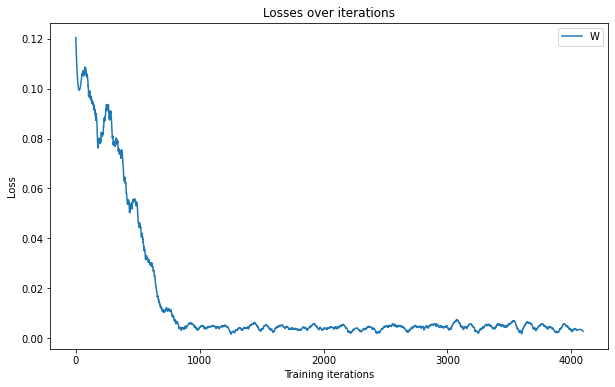

In [8]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
smoothed_losses_w = signal.savgol_filter(losses_w,101,3)
plt.plot(smoothed_losses_w)
plt.legend(['W'])
plt.show()

The plot below shows that the classes 0 and 1 in domain A are weighted to match the uniform distribution in domain B.

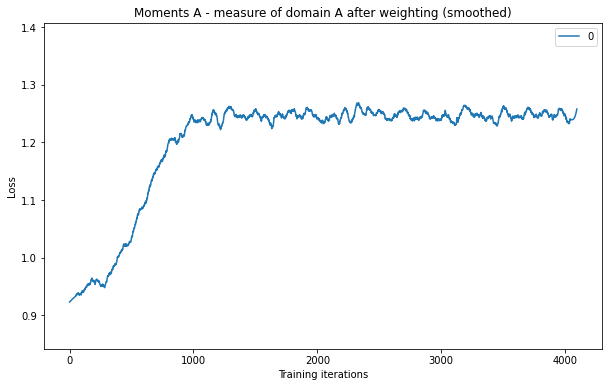

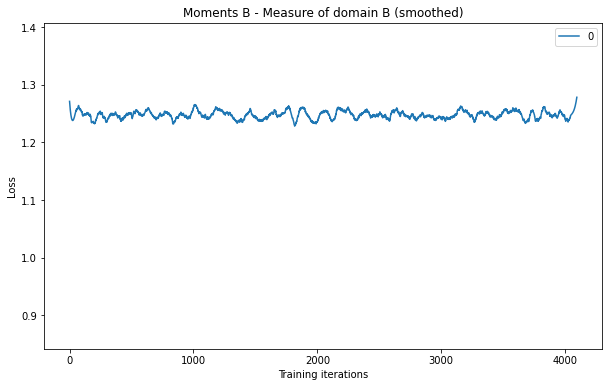

In [16]:
plt.figure(figsize=(10,6))
plt.title('Moments A - measure of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = max(moments_A), ymin = min(moments_A))
smoothed_Lmin = signal.savgol_filter(moments_A,101,3,axis=0)
plt.plot(smoothed_Lmin)
plt.legend(np.arange(len(dataset_A.distribution)))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Moments B - Measure of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = max(moments_A), ymin = min(moments_A))
smoothed_Lplus = signal.savgol_filter(moments_B,101,3,axis=0)
plt.plot(smoothed_Lplus)
plt.legend(np.arange(len(dataset_A.distribution)))
plt.show()

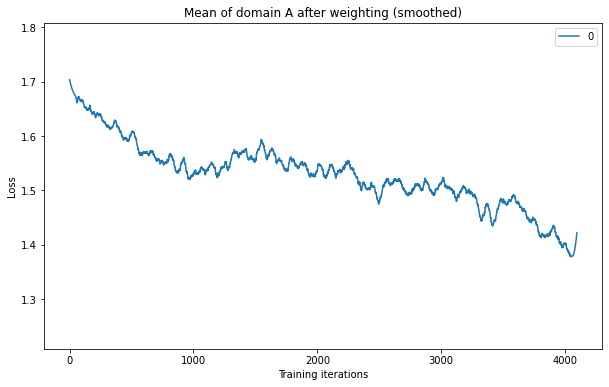

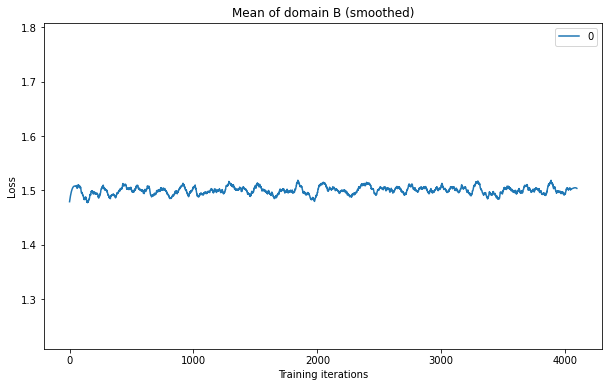

In [17]:
plt.figure(figsize=(10,6))
plt.title('Mean of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = max(means_A), ymin = min(means_A))
smoothed_means_A = signal.savgol_filter(means_A,101,3,axis=0)
plt.plot(smoothed_means_A)
plt.legend(np.arange(len(dataset_A.distribution)))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Mean of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = max(means_A), ymin = min(means_A))
smoothed_means_B = signal.savgol_filter(means_B,101,3,axis=0)
plt.plot(smoothed_means_B)
plt.legend(np.arange(len(dataset_A.distribution)))
plt.show()

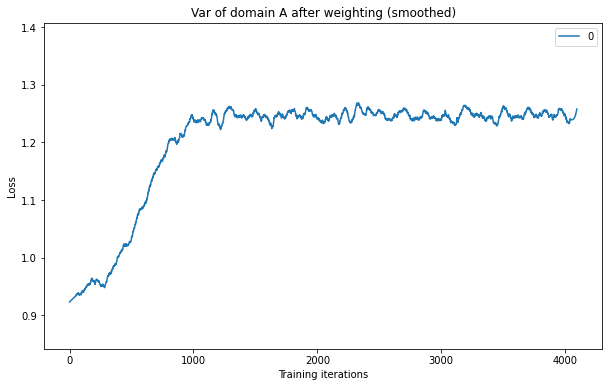

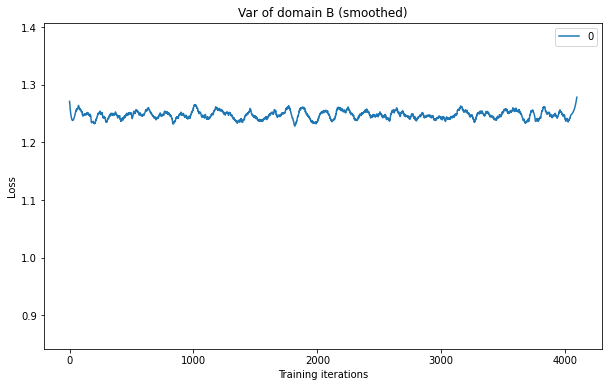

In [18]:
plt.figure(figsize=(10,6))
plt.title('Var of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = max(vars_A), ymin = min(vars_A))
smoothed_vars_A = signal.savgol_filter(vars_A,101,3,axis=0)
plt.plot(smoothed_vars_A)
plt.legend(np.arange(10))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Var of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = max(vars_A), ymin = min(vars_A))
smoothed_vars_B = signal.savgol_filter(vars_B,101,3,axis=0)
plt.plot(smoothed_vars_B)
plt.legend(np.arange(len(dataset_A.distribution)))
plt.show()

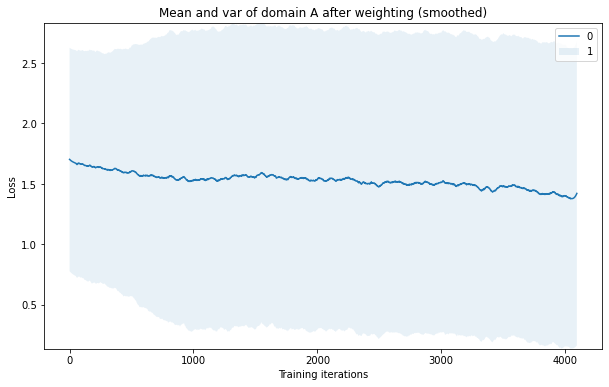

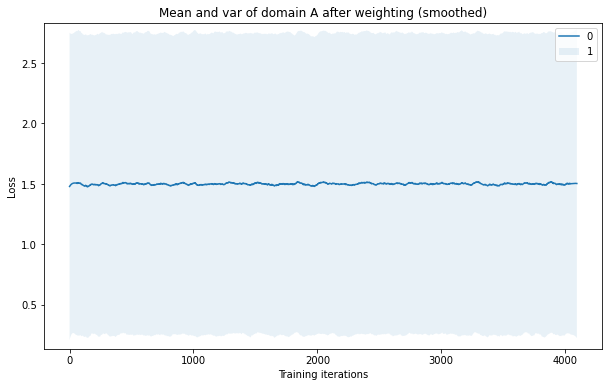

In [23]:
plt.figure(figsize=(10,6))
plt.title('Mean and var of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = max(smoothed_means_A + smoothed_vars_A), ymin = min(smoothed_means_A - smoothed_vars_A))
plt.plot(smoothed_means_A)
for i in range(smoothed_means_A.shape[1]):
  plt.fill_between(np.arange(len(smoothed_means_A)), (smoothed_means_A - smoothed_vars_A)[:, i], (smoothed_means_A + smoothed_vars_A)[:, i], alpha=0.1)
plt.legend(np.arange(len(dataset_A.distribution)))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Mean and var of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.ylim(ymax = max(smoothed_means_A + smoothed_vars_A), ymin = min(smoothed_means_A - smoothed_vars_A))
plt.plot(smoothed_means_B)
for i in range(smoothed_means_B.shape[1]):
  plt.fill_between(np.arange(len(smoothed_means_B)), (smoothed_means_B - smoothed_vars_B)[:, i], (smoothed_means_B + smoothed_vars_B)[:, i], alpha=0.1)
plt.legend(np.arange(len(dataset_A.distribution)))
plt.show()

Here you see the weights assigned to the classes in domain A. As expected, 0 gets a large weight as it is underrepresented in domain A, and 1 gets a small weight as it is overrepresented in domain A.

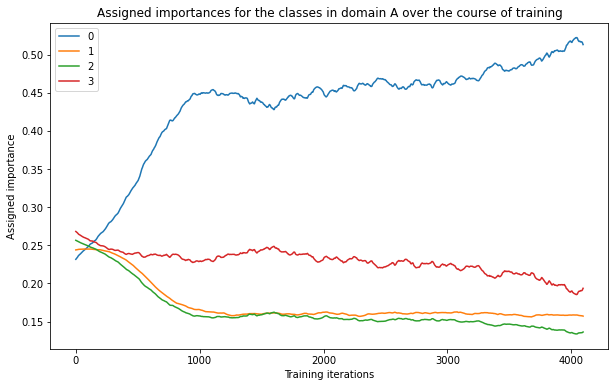

In [24]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the classes in domain A over the course of training')
plt.plot(example_importances_A)
plt.legend(np.arange(10))
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()